In [ ]:
!pip install autogluon

In [ ]:
!pip freeze > requirements.txt

In [ ]:
import pandas as pd
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [ ]:
train_df = pd.read_csv('/mnt/c/Users/wschu/OneDrive/Documents/data/jeju_specialty/open/train.csv')[['ID','timestamp','supply(kg)', 'price(원/kg)']]
test_df = pd.read_csv('/mnt/c/Users/wschu/OneDrive/Documents/data/jeju_specialty/open/test.csv')[['ID','timestamp']]

In [ ]:
train_df['item_id'] = train_df.ID.str[0:6]
test_df['item_id'] = test_df.ID.str[0:6]

In [ ]:
train_df.drop(columns=['ID'])

In [ ]:
test_df.drop(columns=['ID'])

In [ ]:
data = TimeSeriesDataFrame(train_df.drop(columns=['ID']))
test_data = TimeSeriesDataFrame(test_df.drop(columns=['ID']))

In [ ]:
data

In [ ]:
predictor = TimeSeriesPredictor( 
    prediction_length=28,
    target="price(원/kg)",
    eval_metric="RMSE",
)
# seed 고정
predictor.fit(data,
              presets="best_quality",
              random_seed=42,
              )

In [ ]:
predictor.refit_full()

In [30]:
# seed 고정
pred = predictor.predict(data, random_seed=42, )
pred

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


mean          0.1          0.2          0.3  \
item_id timestamp                                                        
TG_A_J  2023-03-04  3201.242118  1210.213249  1997.140703  2473.590486   
        2023-03-05   110.507516 -1631.435967 -1037.873689  -619.960767   
        2023-03-06  3126.654929   703.052400  1729.347001  2288.733421   
        2023-03-07  3013.651418   504.949614  1543.750480  2114.581806   
        2023-03-08  3214.508533   712.197886  1742.972967  2346.021623   
...                         ...          ...          ...          ...   
RD_F_J  2023-03-27   526.058230  -162.348594    86.815397   253.446044   
        2023-03-28   530.510470  -172.900963    83.712136   255.629541   
        2023-03-29   534.537787  -193.431457    65.786046   249.560010   
        2023-03-30   522.782889  -206.414875    55.904852   233.534403   
        2023-03-31   525.086041  -236.037267    40.563059   221.554987   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
TG_A_J  2023-03-04  2904.426023  3223.496726  3580.690763  3959.266830   
        2023-03-05  -253.732810    49.687181   416.691443   777.489249   
        2023-03-06  2732.824496  3112.456860  3492.320243  3915.011524   
        2023-03-07  2565.286820  2956.330759  3399.595184  3829.245623   
        2023-03-08  2802.438605  3201.738765  3628.011029  4090.104303   
...                         ...          ...          ...          ...   
RD_F_J  2023-03-27   393.871509   524.331458   644.901887   783.933982   
        2023-03-28   397.123801   533.125973   664.607076   802.920085   
        2023-03-29   393.287479   530.178868   658.179952   806.486138   
        2023-03-30   383.923266   518.518416   651.404734   797.880181   
        2023-03-31   377.540142   517.562841   661.692488   818.767196   

                            0.8          0.9  
item_id timestamp                             
TG_A_J  2023-03-04  4405.085841  5031.304991  
        2023-03-05  1204.562934  1772.291242  
        2023-03-06  4464.299343  5141.344139  
        2023-03-07  4375.906026  5115.554970  
        2023-03-08  4712.689417  5492.251133  
...                         ...          ...  
RD_F_J  2023-03-27   946.889039  1187.631873  
        2023-03-28   963.518126  1201.025175  
        2023-03-29   979.794092  1221.173087  
        2023-03-30   971.683444  1221.034799  
        2023-03-31   988.189384  1239.077953  

[1092 rows x 10 columns]

In [ ]:
# # The test score is computed using the last
# # prediction_length=48 timesteps of each time series in test_data
# predictor.leaderboard(test_data)

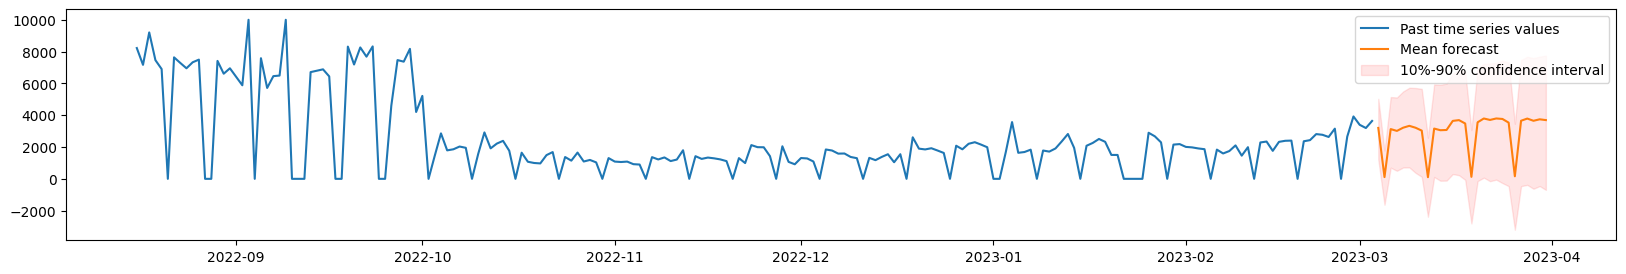

In [31]:
import matplotlib.pyplot as plt

# TimeSeriesDataFrame can also be loaded directly from a file
# test_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv")

plt.figure(figsize=(20, 3))

# item_id = "H1"
item_id = "TG_A_J"
y_past = data.loc[item_id]["price(원/kg)"]
y_pred = pred.loc[item_id]
# y_test = test_data.loc[item_id]["price(원/kg)"][-48:]

plt.plot(y_past[-200:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
# plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();

In [32]:
submission = pd.read_csv('/mnt/c/Users/wschu/OneDrive/Documents/data/jeju_specialty/open/sample_submission.csv')
submission['answer'] = pred.reset_index()['mean']
submission.loc[ submission['answer'] < 0.0, 'answer'] = 0.0
submission.to_csv('/mnt/c/Users/wschu/OneDrive/Documents/data/jeju_specialty/open/dacon_submission.csv', index=False)
submission

,ID,answer
0,TG_A_J_20230304,3201.242118
1,TG_A_J_20230305,110.507516
2,TG_A_J_20230306,3126.654929
3,TG_A_J_20230307,3013.651418
4,TG_A_J_20230308,3214.508533
...,...,...
1087,RD_F_J_20230327,526.058230
1088,RD_F_J_20230328,530.510470
1089,RD_F_J_20230329,534.537787
1090,RD_F_J_20230330,522.782889
